<a href="https://colab.research.google.com/github/ioloi1128/CDA/blob/main/CDA_week3_ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Define

In [4]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import scipy as stats
from scipy.stats import ttest_ind_from_stats

Load data

In [5]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url)
print(ds)
#ds

# select period
ds = ds.sel(time=slice('1960', '2018'))
#ds

#actually load the data
ds.load()

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2030, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-02-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:     

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 708, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2023-03-04
    DODS_EXTRA.Unlimited_Dimension:  time

Process data

In [6]:
#make anomaly
sst_clim = ds.sst.groupby('time.month').mean(dim='time')
sst_anom = ds.sst.groupby('time.month') - sst_clim

In [7]:
#detrend
from scipy.signal import detrend
sst_anom_detrended = xr.apply_ufunc(detrend, sst_anom.fillna(0),
                                    kwargs={'axis': 0}).where(~sst_anom.isnull())

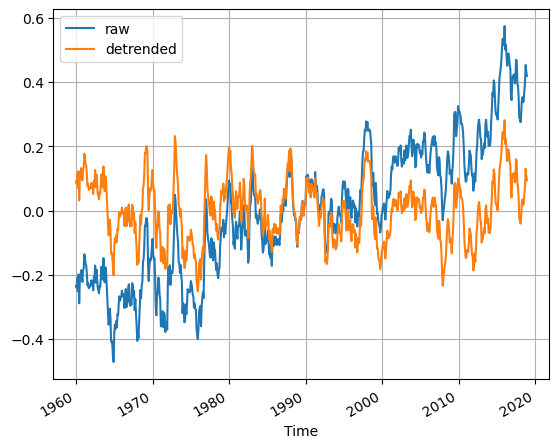

In [8]:
# For a global average, we need to weigh the points by cosine of latitude.
# This is not built into xarray because xarray is not specific to geoscientific data.
weights = np.cos(np.deg2rad(ds.lat)).where(~sst_anom[0].isnull())
weights /= weights.mean()

(sst_anom * weights).mean(dim=['lon', 'lat']).plot(label='raw')
(sst_anom_detrended * weights).mean(dim=['lon', 'lat']).plot(label='detrended')
plt.grid()
plt.legend()

In [9]:
sst_anom_nino34 = sst_anom_detrended.sel(lat=slice(5, -5), lon=slice(190, 240))
sst_anom_nino34_mean = sst_anom_nino34.mean(dim=('lon', 'lat'))
oni = sst_anom_nino34_mean.rolling(time=3, center=True).mean()

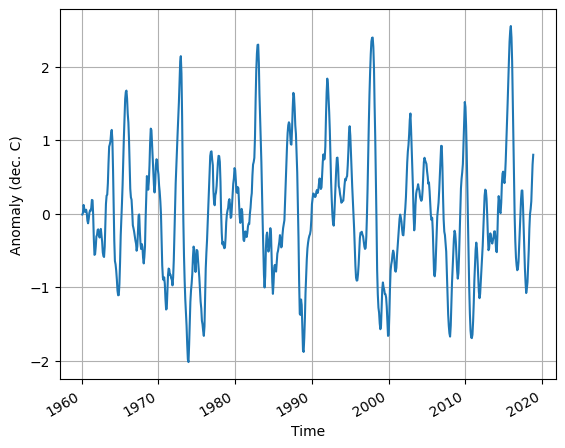

In [10]:
oni.plot()
plt.grid()
plt.ylabel('Anomaly (dec. C)');

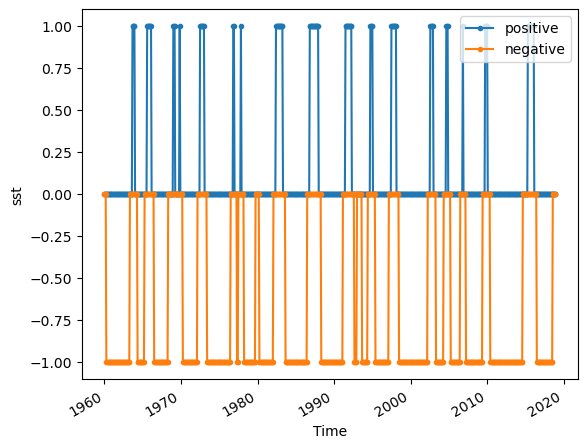

In [11]:
positive_oni = ((oni>0.5).astype('b').rolling(time=5, center=True).sum()==5)
negative_oni = ((oni<0.5).astype('b').rolling(time=5, center=True).sum()==5)
positive_oni.astype('i').plot(marker='.', label='positive')
(-negative_oni.astype('i')).plot(marker='.', label='negative')
plt.legend()

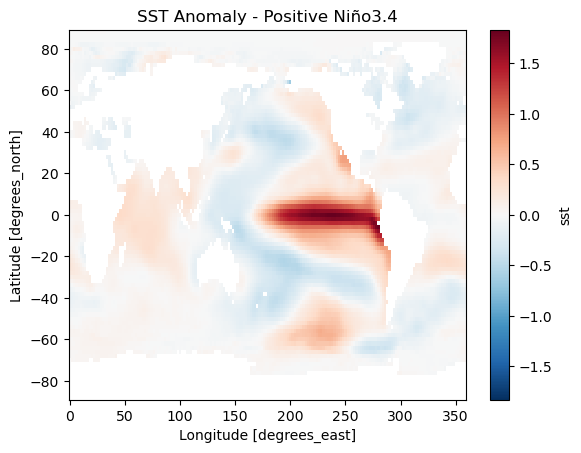

In [12]:
sst_anom.where(positive_oni).mean(dim='time').plot()
plt.title('SST Anomaly - Positive Niño3.4');

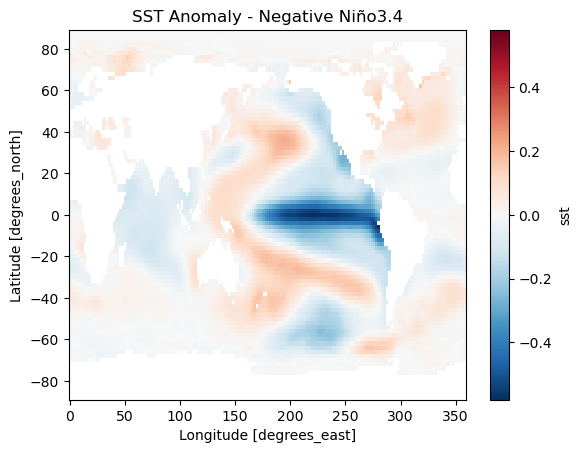

In [13]:
sst_anom.where(negative_oni).mean(dim='time').plot()
plt.title('SST Anomaly - Negative Niño3.4');

Add sifnificant ttest

In [14]:
mean1 = sst_anom.where(positive_oni).mean(dim='time')
mean2 = sst_anom.mean(dim='time')

#mean1.plot()
#mean2.plot()

In [15]:
std1 = sst_anom.where(positive_oni).std(dim='time')
#std1.plot()
std2 = sst_anom.std(dim='time')
#std2.plot()

In [16]:
nobs1 = np.count_nonzero(positive_oni)
#nobs1
nobs2 = len(oni)
#nobs2

In [17]:
modified_std1 = np.sqrt(np.float32(nobs1)/np.float32(nobs1-1)) * std1
#modified_std1
modified_std2 = np.sqrt(np.float32(nobs2)/np.float32(nobs2-1)) * std2
#modified_std2

In [18]:
import scipy.stats as stats
from scipy.stats import ttest_ind, ttest_ind_from_stats

In [19]:
(statistic, pvalue) = stats.ttest_ind_from_stats(mean1=mean1, std1=modified_std1, nobs1=nobs1, mean2=mean2, std2=modified_std2, nobs2=nobs2 )
print(pvalue)

[[0.37354082 0.39731854 0.41454104 ... 0.35031304 0.35256723 0.35490662]
 [0.40572748 0.4174608  0.429323   ... 0.42931578 0.4143844  0.40337378]
 [0.57655674 0.42931852 0.4293156  ... 0.57420313 0.5766678  0.5766796 ]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


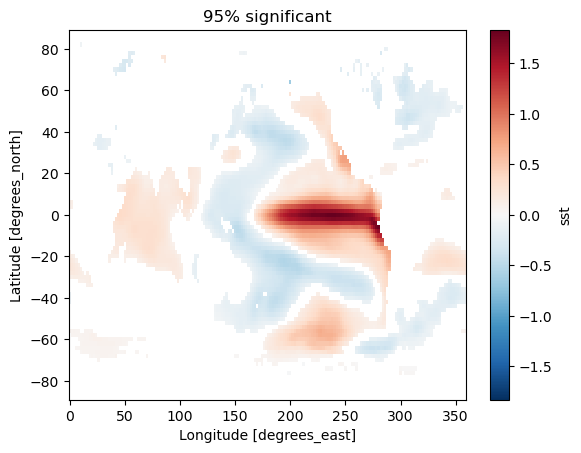

In [20]:
alpha=0.05
mean1_sig=mean1.where(pvalue <= alpha)
mean1_sig.plot()
plt.title('95% significant');

In [21]:
mean1_sig.to_netcdf(path="Elnino_sig.nc")
mean1.to_netcdf(path="Elnino_nosig.nc")